In [1]:
import numpy as np 
import pandas as pd
import os

In [2]:
import tensorflow
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.data import Dataset
import cv2

In [3]:
data_path = "ASL Dataset/train"

labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

data_directory = tensorflow.keras.utils.image_dataset_from_directory(
    data_path,
    class_names = labels,
    color_mode = 'grayscale',
    image_size =(200, 200),
)

test_path = "ASL Dataset/test"


test = tensorflow.keras.utils.image_dataset_from_directory(
    test_path,
    class_names = labels,
    color_mode = 'grayscale',
    image_size =(200, 200),
)

test = data_directory.map(lambda x, y: (x / 255.0, y))

Found 12380 files belonging to 26 classes.
Found 4114 files belonging to 26 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


tf.Tensor(3, shape=(), dtype=int32)


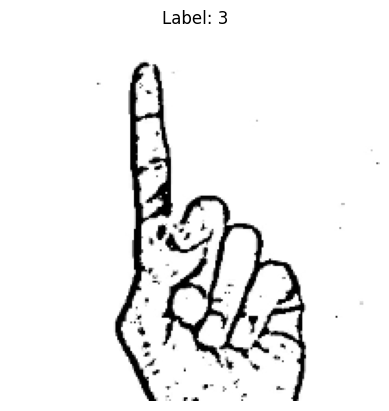

In [4]:
import matplotlib.pyplot as plt

first_element = next(iter(data_directory))

# Extracting the first image and label
first_image = first_element[0][20]
first_label = first_element[1][20]

print(first_label)

import matplotlib.pyplot as plt

plt.imshow(first_image,cmap='gray')
plt.title(f"Label: {first_label}")
plt.axis('off')
plt.show()


In [5]:
train_size = int(len(data_directory)* .9)
cval_size = int(len(data_directory)* .1)

train = data_directory.take(train_size)
cval = data_directory.skip(train_size).take(cval_size)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [7]:
model = Sequential()

model.add(Conv2D(8, (3,3), 1, activation ='relu', input_shape=(200, 200, 1)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation ='relu' ))
model.add(MaxPooling2D())

model.add(Conv2D(8, (3,3), 1, activation ='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(26, activation = 'softmax'))

In [8]:
from tensorflow.keras.optimizers import Adam, SGD

opt = Adam(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.001, momentum = 0.9)

model.compile(optimizer = opt, loss ='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
from keras.callbacks import EarlyStopping

# Define the number of epochs and other parameters
num_epochs = 50
patience = 5  # Number of epochs with no improvement after which training will be stopped

# Define the Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor for improvement
    patience=patience,   # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the weights of the best-performing model
)

# Train the model with Early Stopping
history = model.fit(train, validation_data=cval, epochs=num_epochs, callbacks=[early_stopping])


Epoch 1/50
348/348 [==============================] - 76s 217ms/step - loss: 0.7177 - accuracy: 0.8790 - val_loss: 0.0298 - val_accuracy: 0.9901
Epoch 2/50
348/348 [==============================] - 75s 216ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 9.9738e-04 - val_accuracy: 1.0000
Epoch 3/50
348/348 [==============================] - 76s 217ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0173 - val_accuracy: 0.9951
Epoch 4/50
348/348 [==============================] - 75s 216ms/step - loss: 0.0609 - accuracy: 0.9857 - val_loss: 0.0498 - val_accuracy: 0.9901
Epoch 5/50
348/348 [==============================] - 76s 218ms/step - loss: 0.0155 - accuracy: 0.9960 - val_loss: 0.0098 - val_accuracy: 0.9992
Epoch 6/50
348/348 [==============================] - 76s 219ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0015 - val_accuracy: 0.9992
Epoch 7/50
348/348 [==============================] - 76s 217ms/step - loss: 1.7717e-04 - accuracy: 0.9999 - val_loss: 0.0039 

In [10]:
model.summary() 

loss, accuracy = model.evaluate(test)

print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

final_val_loss = val_loss[-1]
final_val_accuracy = val_accuracy[-1]
print('Final Validation Loss:', final_val_loss)
print('Final Validation Accuracy:', final_val_accuracy)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 8)         1160      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 8)        0

In [11]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


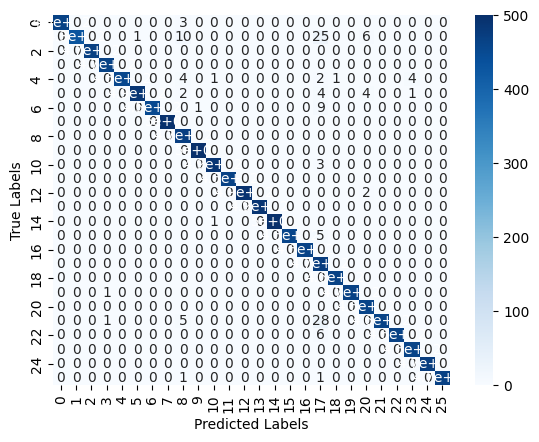

Precision: 0.989
Recall: 0.989
F1 Score: 0.989


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Generate some random data
y_true = []
y_pred = []

for image, label in test:
    
    pred = model.predict_on_batch(image)
    for prediction in pred:
        y_pred.append(np.argmax(prediction))
        
    for lab in label:
        y_true.append(lab)
    

# Create the confusion matrix
confusion_matrix = tensorflow.math.confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using a heatmap
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print('Precision: %.3f' % precision_score(y_true, y_pred, average='micro' ))
print('Recall: %.3f' % recall_score(y_true, y_pred, average = 'micro'))
print('F1 Score: %.3f' % f1_score(y_true, y_pred, average='micro'))

In [18]:
model.save('model.h5')

In [43]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [48]:
import math
import numpy as np
import cv2
import matplotlib.image as mpimg

def result(frame, hand):

    BOXOFFSET = 20
    IMGSIZE = 200
    x,y,w,h = hand['bbox']

    aspectratio = h/w

    croppedimg = frame[y-BOXOFFSET:y+h+BOXOFFSET, x-BOXOFFSET:x+w+BOXOFFSET]

    whiteimg = np.ones((IMGSIZE,IMGSIZE,3),np.uint8)*255

    if aspectratio > 1:
        k = IMGSIZE / h
        wc = math.ceil(k*w)
        hc = IMGSIZE

    else:
        k = IMGSIZE /w
        hc = math.ceil(k*h)
        wc = IMGSIZE

    imgresize = cv2.resize(croppedimg, (wc, hc))
    sx = math.ceil((IMGSIZE-imgresize.shape[0])/2)
    sy = math.ceil((IMGSIZE-imgresize.shape[1])/2)
    whiteimg[sx:imgresize.shape[0]+sx,sy:imgresize.shape[1]+sy] = imgresize

    gray = cv2.cvtColor(whiteimg, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),2)
    th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    ret, res = cv2.threshold(th3, 70, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    finalimage = res.astype('float32') / 255.0
    finalimage = np.expand_dims(finalimage, axis=0)
    prediction = model.predict(finalimage)


    return  prediction


In [49]:
import cv2
from cvzone.HandTrackingModule import HandDetector

try:
    cam = cv2.VideoCapture(0)
    detect = HandDetector(maxHands=1)

    cv2.namedWindow("Hand Gesture")

    string = ""

    img_counter = 0
    offset = 30
    captured_result = []

    while True:
        

        success, frame = cam.read()

        output = frame.copy()

        k = cv2.waitKey(1)
        
        if k%256 == 27:
            print("Application exited")
            break

        hands, frame = detect.findHands(frame)

        if hands:
            hand= hands[0]
            x, y, w, h = hand['bbox']

            index = result(frame, hand)
            index = np.argmax(result(frame, hand))

            cv2.putText(output, labels[index], (x, y-30),cv2.FONT_HERSHEY_SIMPLEX, 2,(250, 0, 250),2)
            cv2.rectangle(output, (x - offset, y - offset), (x+w+offset, y+h+offset), (250, 0, 250), 4)
            cv2.putText(output,str(img_counter), (20, 20),cv2.FONT_HERSHEY_SIMPLEX, 2,(250, 0, 250),2)

            if len(captured_result) == 50:
            # Find the most frequent letter in the captured results
                most_frequent_letter = max(set(captured_result), key=captured_result.count)
                string += most_frequent_letter
                img_counter = 0
                captured_result = []
            else:
                img_counter += 1
                captured_result.append(labels[index])

        cv2.imshow("Sign", output)

    cam.release()
    cv2.destroyAllWindows()

except:
    print("There was a crash")
    print(string)
    cam.release()
    cv2.destroyAllWindows()


1/1 [==============================] - 0s 33ms/step
Application exited
